### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [1]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-05-07 17:48:06--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat’

ising2_label.dat    100%[===================>]  79.13K   253KB/s    in 0.3s    

2020-05-07 17:48:07 (253 KB/s) - ‘ising2_label.dat’ saved [81025/81025]

--2020-05-07 17:48:09--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M  9.36MB/s    in 1.9s    

2020-05-07 17:48:11 (9.36 MB/s) - ‘ising2_conf.dat’ saved [19060775/19060775

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [2]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-rc4


In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [4]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


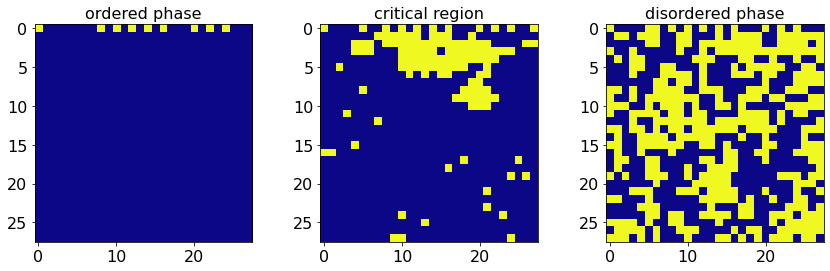

In [5]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [6]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
data = (X_train,X_test,Y_train,Y_test)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

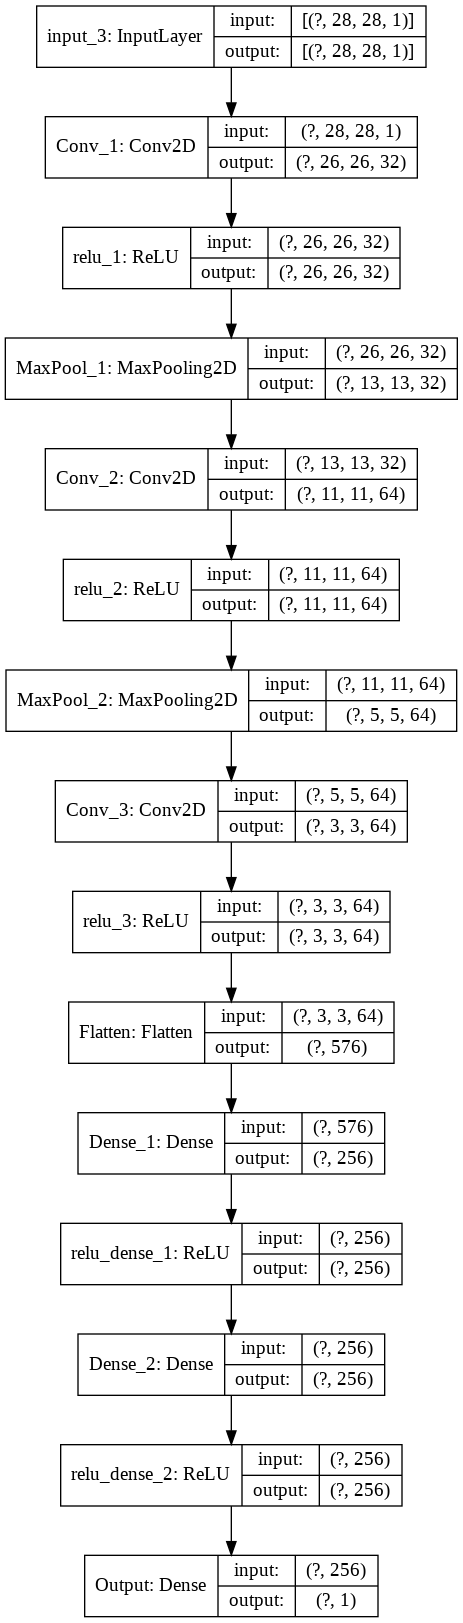

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
def output_from_input(
    inputs, data_augment=False, activation="relu",
    batch_normalize=False
):
  if activation=="relu":
    _layer_with_activation = keras.layers.ReLU
  elif activation=="l_relu":
    _layer_with_activation = keras.layers.LeakyReLU
  elif activation=="elu":
    _layer_with_activation = keras.layers.ELU

  if data_augment:
    x = data_augmentation(inputs)
  else:
    x = inputs

  if batch_normalize:
    layer_with_activation = lambda name, x: \
      keras.layers.BatchNormalization()(_layer_with_activation(name=name)(x))
  else:
    layer_with_activation = lambda name, x: \
      _layer_with_activation(name=name)(x)
  # CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
  # da una rete densa come classificatore

  #
  # singolo blocco convoluzionale: conv2D + maxPooling 
  # attvazione: ReLu

  # primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
  #tf.keras.layers.Conv2D(
  #    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
  #    dilation_rate=(1, 1), activation=None, use_bias=True,
  #    kernel_initializer='glorot_uniform', bias_initializer='zeros',
  #    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
  #    kernel_constraint=None, bias_constraint=None, **kwargs
  #)
  #tf.keras.layers.ReLU(
  #    max_value=None, negative_slope=0, threshold=0, **kwargs
  #)
  #tf.keras.layers.MaxPool2D(
  #    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
  #)
  # NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
  # ridurre la size dell'immagine dopo lapplicazione del filtro

  #
  # primo blocco Convoluzionale
  x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
  x = layer_with_activation(f'{activation}_1', x)
  x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

  # secondo blocco convoluzionale
  x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
  x = layer_with_activation(f'{activation}_2', x)
  x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

  # terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
  # troppo la dimensione dell'output x)
  x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
  x = layer_with_activation(f'{activation}_3', x)

  # appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
  # vettore piatto come input per la rete densa

  x = keras.layers.Flatten(name='Flatten')(x)

  # rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
  # layer di uscita costituito da 1 neurone con funzione di attivazione lineare
  # che produce in output la stima della temperatura associata alla configurazione
  # in input

  # Layer denso in Keras
  #tf.keras.layers.Dense(
  #    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
  #    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
  #    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
  #    **kwargs
  #)
  x = keras.layers.Dense(256, name='Dense_1')(x)
  x = layer_with_activation(f'{activation}_dense_1', x)
  x = keras.layers.Dense(256, name='Dense_2')(x)
  x = layer_with_activation(f'{activation}_dense_2', x)
  outputs = keras.layers.Dense(1, name='Output')(x)
  return outputs

outputs = output_from_input(inputs)
#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ 
  model_checkpoint, 
  #lr_scheduler,
]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 19ms/step - loss: 0.6108 - mean_absolute_error: 0.5752 - val_loss: 0.2322 - val_mean_absolute_error: 0.4137
Epoch 2/30
50/50 [==============================] - 1s 14ms/step - loss: 0.2191 - mean_absolute_error: 0.3962 - val_loss: 0.1925 - val_mean_absolute_error: 0.3685
Epoch 3/30
50/50 [==============================] - 1s 14ms/step - loss: 0.1983 - mean_absolute_error: 0.3695 - val_loss: 0.1928 - val_mean_absolute_error: 0.3569
Epoch 4/30
50/50 [==============================] - 1s 13ms/step - loss: 0.1628 - mean_absolute_error: 0.3293 - val_loss: 0.1488 - val_mean_absolute_error: 0.3126
Epoch 5/30
50/50 [==============================] - 1s 13ms/step - loss: 0.1348 - mean_absolute_error: 0.2966 - val_loss: 0.1332 - val_mean_absolute_error: 0.2981
Epoch 6/30
50/50 [==============================] - 1s 13ms/step - loss: 0.1266 - mean_absolute_error: 0.2857 - val_loss: 0.1296 - val_mean_absolute_error: 0.2898
Epoch 7/30
50/50 [====

In [0]:
model.load_weights("mycnn_29")
model.save("/content/drive/My Drive/Colab Notebooks/mycnn_29.hdf5")

In [0]:
# model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/mycnn_29.hdf5")

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0945 - mean_absolute_error: 0.2320

Test loss (MSE): 0.09447386860847473

Test MAE: 0.23198005557060242


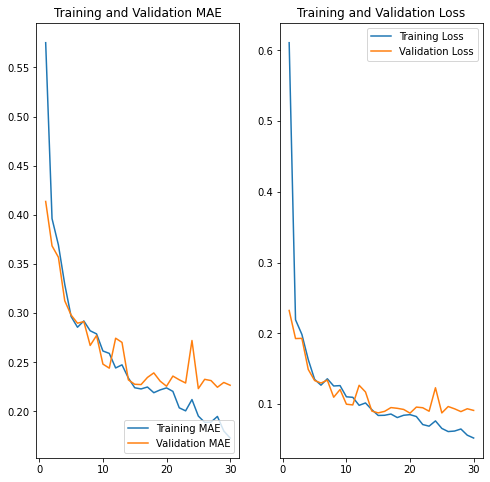

In [0]:
#plot della loss e della MAE durante il training
def plot_history(history):
  train_mae = history.history['mean_absolute_error']
  val_mae = history.history['val_mean_absolute_error']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(1, len(loss) + 1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_mae, label='Training MAE')
  plt.plot(epochs_range, val_mae, label='Validation MAE')
  plt.legend(loc='lower right')
  plt.title('Training and Validation MAE')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
plot_history(history)

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 3.110633 VS 3.114210 Diff= -0.003577
Predicted vs True T: 1.720218 VS 1.887960 Diff= -0.167742
Predicted vs True T: 2.939954 VS 2.701660 Diff= 0.238294
Predicted vs True T: 1.547025 VS 1.556840 Diff= -0.009815
Predicted vs True T: 3.484708 VS 3.394530 Diff= 0.090178
Predicted vs True T: 2.940617 VS 2.890170 Diff= 0.050447
Predicted vs True T: 3.946446 VS 4.469660 Diff= -0.523213
Predicted vs True T: 1.830429 VS 1.596210 Diff= 0.234219
Predicted vs True T: 2.369776 VS 2.215780 Diff= 0.153996
Predicted vs True T: 4.278232 VS 4.072530 Diff= 0.205702
Sample MAE:  [0.16771834]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc
def classify(model, X_test, Y_test, T_c):
  T_c=2.26 # Temperatura critica

  # predizioni della CNN sull'intero campione di Test
  predictions = model.predict(X_test)


  # conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
  N_ord_corrette = 0 
  N_dis_corrette = 0
  N_all = 0
  for i in range(predictions.shape[0]):
    if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
      N_ord_corrette = N_ord_corrette + 1
    if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
      N_dis_corrette = N_dis_corrette + 1

  N_all = Y_test.shape[0]   

  accuracy = (N_ord_corrette+N_dis_corrette)/N_all
  print('Accuracy is: ', accuracy)

classify(model, X_test, Y_test, 2.26)

Accuracy is:  0.9795


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

# Attivare learning rate decay

In [0]:
def create_model_and_train(
    X_train, X_test, Y_train, Y_test, 
    optional_callbacks, **kwargs
):
  outputs = output_from_input(inputs, **kwargs)
  #definizione del modello
  model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

  #printout il summary del modello
  model.summary()

  # struttura el modello
  keras.utils.plot_model(model, show_shapes=True)

  OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
  mse = tf.keras.losses.MeanSquaredError()
  mae = tf.keras.metrics.MeanAbsoluteError()

  model.compile(
      optimizer=OPTIMIZER,
      loss=mse,
      metrics=[mae]
)

  model_checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.hdf5", monitor='val_loss', verbose=1,
    save_weights_only=True,
    save_best_only=True, mode='auto', save_freq="epoch")

  callbacks = [model_checkpoint] + optional_callbacks
  history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                      validation_split=0.2, shuffle=True, verbose=2,
                      callbacks=callbacks)

  model.load_weights("best_model.hdf5")
  test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=2)
  print('\nTest loss (MSE):', test_loss)
  print('\nTest MAE:', test_mae)
  plot_history(history)
  classify(model, X_test, Y_test, 2.26)
  return (history, model)

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

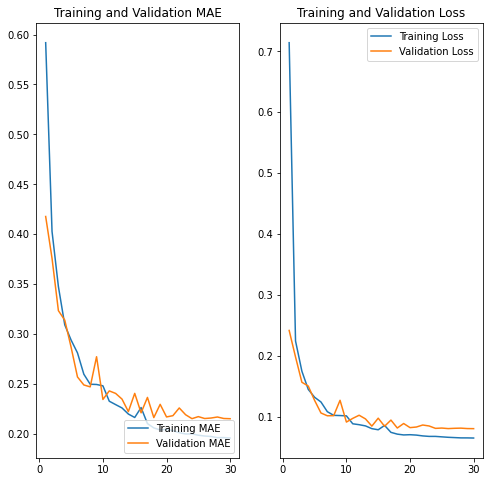

Accuracy is:  0.9795


(<tensorflow.python.keras.callbacks.History at 0x7fc2f102a828>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f0022668>)

In [0]:
LR_ST = 1e-3
# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    eta = LR_ST
  else:
    eta = LR_ST * tf.math.exp(0.2 * (10 - epoch))
  print(f"learning rate: {float(eta)}")
  return eta

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

create_model_and_train(*data, [lr_scheduler])

Avendo attivato il learning rate decay le prestazioni sono leggermente migliorate. Si può notare dal grafico di MAE e loss come l'andamento sia diventato asintoticamente piatto.

# Attivare Data Augmentation

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0 

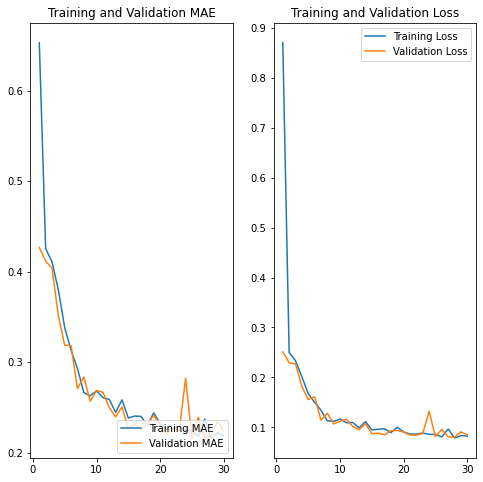

Accuracy is:  0.9785


(<tensorflow.python.keras.callbacks.History at 0x7fc2f04da9b0>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f04fe588>)

In [0]:
create_model_and_train(*data, [], data_augment=True)

Si ha ancora un miglioramento rispetto alla baseline. Si nota inoltre una riduzione significativa del gap di generalizzazione.

# Altre funzioni di attivazione

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
l_relu_1 (LeakyReLU)         (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
l_relu_2 (LeakyReLU)         (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

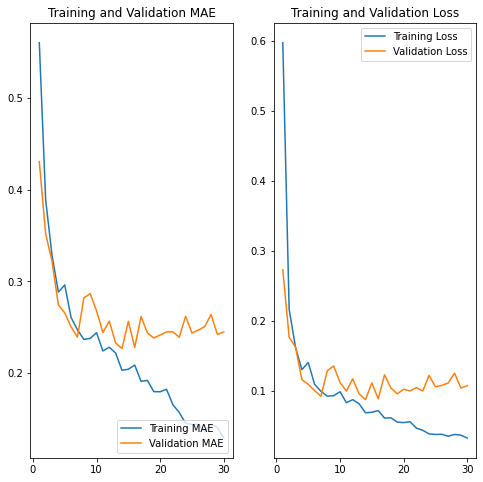

Accuracy is:  0.977


(<tensorflow.python.keras.callbacks.History at 0x7fc2f012c630>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f02c0240>)

In [0]:
create_model_and_train(*data, [], activation="l_relu")

Si nota come con la *Leaky ReLu* l'errore di validazione cominci a crescere prima, si ha quindi overfitting precoce.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
elu_1 (ELU)                  (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
elu_2 (ELU)                  (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

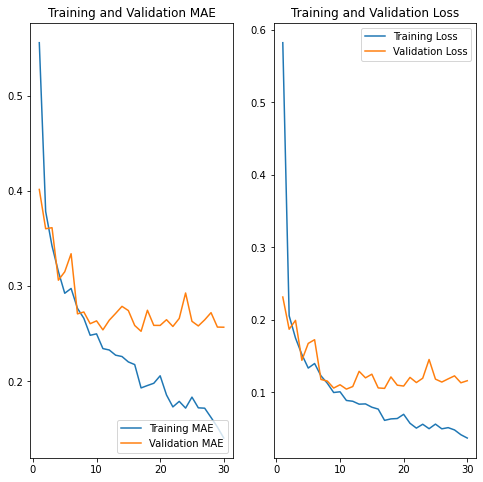

Accuracy is:  0.9635


(<tensorflow.python.keras.callbacks.History at 0x7fc2f105ce48>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f01ea6d8>)

In [0]:
create_model_and_train(*data, [], activation="elu")

Un fenomeno simile si ha con la *ELu*.

# Attivazione Batch Normalization

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0 

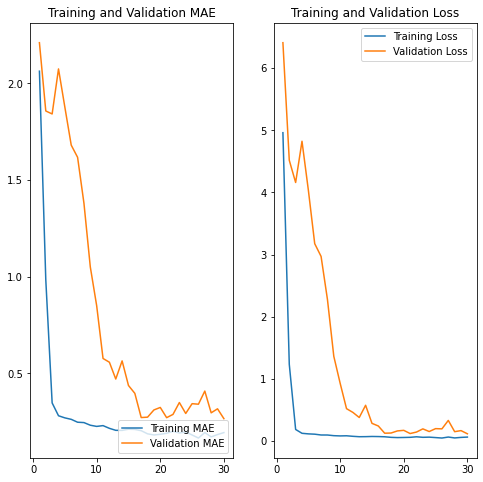

Accuracy is:  0.9835


(<tensorflow.python.keras.callbacks.History at 0x7fc2ea33a3c8>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2ea464e10>)

In [0]:
create_model_and_train(*data, [], batch_normalize=True)

Si nota un grande aumento dell'errore di generalizzazione, a discapito di una convergenza molto accelerata, con una *training loss* che diventa quasi statica dopo poche epoche.

**Trovare gi iprparametri ottimali del modello con** *Keras Tuner*

Dato un modello funzionante il passo successivo è quello di ottimizzarne l'archiettura. Questo può essere fatto manualmente (alcuni esempi li abbiamo visti sopra intorducendo il decay del learning rate o introducendo procedure di data_augmentation), oppure in modo sistematico usando tool appositi. Uno di tali tool, semplice e che funziona con keras è appunto [*Keras Tuner*](https://keras-team.github.io/keras-tuner/)


Uso:

1.   si modifica la definizione del modello in modo che acectti un parametro *hp* e in modo tale da modificare gli iperparametri del modello in accordo a diversi metodi di sampling *(hp.Int(), hp.Choice(), ...)*  
2.   si istanzia un oggetto di tipo *tuner* che definisce la strategia di tuning da seguire
3.   si fa partire la ricerca dei parametri e si prina il risultato finale

Esempio pratico:

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))

  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')

  activation = "relu"

  x = data_augmentation(inputs)

  batch_normalize = hp.Choice("batch_normalize", values=[True, False])
  if batch_normalize:
    layer_with_activation = lambda name, x: \
      keras.layers.BatchNormalization()(keras.layers.ReLU(name=name)(x))
  else:
    layer_with_activation = lambda name, x: \
      keras.layers.ReLU(name=name)(x)

  av_or_max = hp.Choice("average or max", values=["max", "av"])
  av_or_max_layer = (
    keras.layers.MaxPooling2D, keras.layers.AveragePooling2D
  )[av_or_max=="av"]
  ks = hp.Choice("kernel_size", values=[2, 3, 4])
  f1 = hp.Choice("filter 1", values=[16, 32, 64])
  x = keras.layers.Conv2D(f1, kernel_size=(ks,ks), name='Conv_1')(x)
  x = layer_with_activation(f'{activation}_1', x)
  x = av_or_max_layer((2,2), name='MaxPool_1')(x)
  f2 = hp.Choice("filter 2", values=[16, 32, 64])
  x = keras.layers.Conv2D(f2, kernel_size=(ks,ks), name='Conv_2')(x)
  x = layer_with_activation(f'{activation}_2', x)
  x = av_or_max_layer((2,2), name='MaxPool_2')(x)
  f3 = hp.Choice("filter 3", values=[16, 32, 64])

  x = keras.layers.Conv2D(f3, kernel_size=(ks,ks), name='Conv_3')(x)
  x = layer_with_activation(f'{activation}_3', x)

  x = keras.layers.Flatten(name='Flatten')(x)

  dense_n = hp.Choice("dense_n", values=[64, 128, 256])
  x = keras.layers.Dense(dense_n, name='Dense_1')(x)
  x = layer_with_activation(f'{activation}_dense_1', x)
  x = keras.layers.Dense(dense_n, name='Dense_2')(x)
  x = layer_with_activation(f'{activation}_dense_2', x)
  outputs = keras.layers.Dense(1, name='Output')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Float("learning rate", min_value=3e-4, max_value=5e-3)),
        loss='mse',
        metrics=['mae'])
  return model

In [32]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 9.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=e3452d13986a9abb1c41663cc655fd1e072a81fda3ea65d55e438d0fe80413a3
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=2f0780b9c28434687b10af341aca65fb4a335dab6fee25207ae2f638fa1a5acf
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [46]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
import kerastuner
 
tuner = kerastuner.tuners.BayesianOptimization(
  build_model,
  objective='val_mae',
  max_trials=100,
  executions_per_trial=2,
  directory='ottim_dir')

INFO:tensorflow:Reloading Oracle from existing project ottim_dir/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ottim_dir/untitled_project/tuner0.json


In [0]:
# start optimisation search
X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

tuner.search(X_t, Y_t, 
             epochs=50, validation_data=(X_v, Y_v), 
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=10)]
             )

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.6207 - mae: 0.5672 - val_loss: 0.2012 - val_mae: 0.3701
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2241 - mae: 0.3901 - val_loss: 0.1580 - val_mae: 0.3330
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1775 - mae: 0.3387 - val_loss: 0.1692 - val_mae: 0.3387
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1677 - mae: 0.3319 - val_loss: 0.1211 - val_mae: 0.2741
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1597 - mae: 0.3192 - val_loss: 0.2039 - val_mae: 0.3715
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1355 - mae: 0.2880 - val_loss: 0.1346 - val_mae: 0.2915
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1364 - mae: 0.2896 - val_loss: 0.1107 - val_mae: 0.2662
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 1.6240 - mae: 0.9228 - val_loss: 1.5834 - val_mae: 1.0530
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2693 - mae: 0.4121 - val_loss: 0.9625 - val_mae: 0.7682
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2507 - mae: 0.3951 - val_loss: 0.8773 - val_mae: 0.7322
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2250 - mae: 0.3775 - val_loss: 0.5739 - val_mae: 0.5629
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2551 - mae: 0.4001 - val_loss: 0.2411 - val_mae: 0.3734
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2161 - mae: 0.3695 - val_loss: 0.4069 - val_mae: 0.4876
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2176 - mae: 0.3690 - val_loss: 0.2281 - val_mae: 0.3666
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.5389 - mae: 0.5124 - val_loss: 0.2158 - val_mae: 0.3871
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2054 - mae: 0.3742 - val_loss: 0.2092 - val_mae: 0.3748
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1714 - mae: 0.3371 - val_loss: 0.1494 - val_mae: 0.3163
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1667 - mae: 0.3249 - val_loss: 0.2125 - val_mae: 0.3682
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1415 - mae: 0.2979 - val_loss: 0.1169 - val_mae: 0.2594
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1415 - mae: 0.2957 - val_loss: 0.1777 - val_mae: 0.3362
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1260 - mae: 0.2765 - val_loss: 0.1045 - val_mae: 0.2532
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.4596 - mae: 0.5082 - val_loss: 0.2560 - val_mae: 0.4245
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2453 - mae: 0.4164 - val_loss: 0.2670 - val_mae: 0.4332
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1918 - mae: 0.3616 - val_loss: 0.1994 - val_mae: 0.3569
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1600 - mae: 0.3246 - val_loss: 0.1332 - val_mae: 0.2959
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1465 - mae: 0.3056 - val_loss: 0.1316 - val_mae: 0.2866
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1381 - mae: 0.2976 - val_loss: 0.1307 - val_mae: 0.2910
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1233 - mae: 0.2813 - val_loss: 0.1188 - val_mae: 0.2760
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.5482 - mae: 0.5205 - val_loss: 0.1862 - val_mae: 0.3552
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1982 - mae: 0.3661 - val_loss: 0.1906 - val_mae: 0.3567
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1792 - mae: 0.3451 - val_loss: 0.1610 - val_mae: 0.3291
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1465 - mae: 0.3070 - val_loss: 0.1235 - val_mae: 0.2762
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1352 - mae: 0.2921 - val_loss: 0.1545 - val_mae: 0.3126
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1239 - mae: 0.2767 - val_loss: 0.2889 - val_mae: 0.4414
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1194 - mae: 0.2735 - val_loss: 0.1058 - val_mae: 0.2545
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.4858 - mae: 0.4872 - val_loss: 0.1849 - val_mae: 0.3466
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1988 - mae: 0.3674 - val_loss: 0.1590 - val_mae: 0.3219
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1784 - mae: 0.3427 - val_loss: 0.1523 - val_mae: 0.3044
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1323 - mae: 0.2913 - val_loss: 0.1185 - val_mae: 0.2748
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1135 - mae: 0.2642 - val_loss: 0.1153 - val_mae: 0.2713
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1081 - mae: 0.2579 - val_loss: 0.1011 - val_mae: 0.2421
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1268 - mae: 0.2803 - val_loss: 0.1079 - val_mae: 0.2551
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 2.7380 - mae: 1.3502 - val_loss: 1.5606 - val_mae: 1.0568
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.3067 - mae: 0.4414 - val_loss: 0.9114 - val_mae: 0.7510
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2553 - mae: 0.4016 - val_loss: 0.5712 - val_mae: 0.5625
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2322 - mae: 0.3800 - val_loss: 0.4019 - val_mae: 0.4773
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2087 - mae: 0.3633 - val_loss: 0.2171 - val_mae: 0.3451
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2052 - mae: 0.3588 - val_loss: 0.1828 - val_mae: 0.3371
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2126 - mae: 0.3665 - val_loss: 0.2056 - val_mae: 0.3562
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.5119 - mae: 0.5270 - val_loss: 0.2126 - val_mae: 0.3932
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2371 - mae: 0.4078 - val_loss: 0.1913 - val_mae: 0.3685
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1893 - mae: 0.3603 - val_loss: 0.1942 - val_mae: 0.3526
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1716 - mae: 0.3364 - val_loss: 0.1408 - val_mae: 0.3063
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1668 - mae: 0.3300 - val_loss: 0.1560 - val_mae: 0.3194
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1542 - mae: 0.3174 - val_loss: 0.1320 - val_mae: 0.2941
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1399 - mae: 0.2996 - val_loss: 0.1404 - val_mae: 0.3043
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.6675 - mae: 0.5517 - val_loss: 0.2481 - val_mae: 0.4194
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2042 - mae: 0.3731 - val_loss: 0.1887 - val_mae: 0.3664
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1957 - mae: 0.3650 - val_loss: 0.1588 - val_mae: 0.3212
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1968 - mae: 0.3654 - val_loss: 0.1516 - val_mae: 0.3226
Epoch 5/50
125/125 [==============================] - 1s 4ms/step - loss: 0.1641 - mae: 0.3304 - val_loss: 0.2181 - val_mae: 0.3879
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1517 - mae: 0.3172 - val_loss: 0.1170 - val_mae: 0.2743
Epoch 7/50
125/125 [==============================] - 1s 4ms/step - loss: 0.1376 - mae: 0.2996 - val_loss: 0.1147 - val_mae: 0.2769
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 2.1719 - mae: 1.1064 - val_loss: 1.2940 - val_mae: 0.9472
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2990 - mae: 0.4296 - val_loss: 1.2198 - val_mae: 0.9158
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2547 - mae: 0.4015 - val_loss: 0.6582 - val_mae: 0.6534
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2305 - mae: 0.3749 - val_loss: 0.5691 - val_mae: 0.5968
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2373 - mae: 0.3832 - val_loss: 0.1314 - val_mae: 0.2765
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2052 - mae: 0.3555 - val_loss: 0.1332 - val_mae: 0.2784
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2181 - mae: 0.3713 - val_loss: 0.1857 - val_mae: 0.3341
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.5141 - mae: 0.5026 - val_loss: 0.2468 - val_mae: 0.4102
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1924 - mae: 0.3627 - val_loss: 0.1609 - val_mae: 0.3237
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1778 - mae: 0.3400 - val_loss: 0.1520 - val_mae: 0.3111
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1644 - mae: 0.3221 - val_loss: 0.2096 - val_mae: 0.3872
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1306 - mae: 0.2846 - val_loss: 0.1140 - val_mae: 0.2693
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1257 - mae: 0.2787 - val_loss: 0.1149 - val_mae: 0.2703
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1361 - mae: 0.2907 - val_loss: 0.0993 - val_mae: 0.2502
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.6448 - mae: 0.5564 - val_loss: 0.2087 - val_mae: 0.3871
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2106 - mae: 0.3760 - val_loss: 0.1437 - val_mae: 0.3119
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1756 - mae: 0.3350 - val_loss: 0.1526 - val_mae: 0.2981
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1673 - mae: 0.3236 - val_loss: 0.2185 - val_mae: 0.3877
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1443 - mae: 0.3026 - val_loss: 0.1279 - val_mae: 0.2893
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1448 - mae: 0.3009 - val_loss: 0.1051 - val_mae: 0.2558
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1408 - mae: 0.2959 - val_loss: 0.1260 - val_mae: 0.2708
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 1.3206 - mae: 0.7655 - val_loss: 0.9286 - val_mae: 0.7808
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.3156 - mae: 0.4503 - val_loss: 0.6948 - val_mae: 0.6674
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2784 - mae: 0.4174 - val_loss: 0.4754 - val_mae: 0.5251
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2864 - mae: 0.4185 - val_loss: 0.2612 - val_mae: 0.4076
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2796 - mae: 0.4167 - val_loss: 0.2826 - val_mae: 0.4506
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2840 - mae: 0.4133 - val_loss: 1.3400 - val_mae: 0.8340
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2431 - mae: 0.3908 - val_loss: 0.5616 - val_mae: 0.5346
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 1.5566 - mae: 0.7945 - val_loss: 0.2824 - val_mae: 0.4396
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2265 - mae: 0.3994 - val_loss: 0.1898 - val_mae: 0.3495
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1869 - mae: 0.3525 - val_loss: 0.1508 - val_mae: 0.3176
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1791 - mae: 0.3372 - val_loss: 0.1864 - val_mae: 0.3233
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1456 - mae: 0.2994 - val_loss: 0.1424 - val_mae: 0.2954
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1437 - mae: 0.2983 - val_loss: 0.1892 - val_mae: 0.3281
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1754 - mae: 0.3314 - val_loss: 0.1390 - val_mae: 0.2868
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.7906 - mae: 0.6119 - val_loss: 0.2422 - val_mae: 0.4104
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2417 - mae: 0.4107 - val_loss: 0.1957 - val_mae: 0.3686
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2022 - mae: 0.3726 - val_loss: 0.1820 - val_mae: 0.3579
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1940 - mae: 0.3629 - val_loss: 0.1738 - val_mae: 0.3413
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1791 - mae: 0.3495 - val_loss: 0.1701 - val_mae: 0.3350
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1774 - mae: 0.3450 - val_loss: 0.2102 - val_mae: 0.3699
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1705 - mae: 0.3380 - val_loss: 0.2189 - val_mae: 0.3846
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 1.2854 - mae: 0.6103 - val_loss: 0.1693 - val_mae: 0.3384
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1455 - mae: 0.3021 - val_loss: 0.0983 - val_mae: 0.2490
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1197 - mae: 0.2718 - val_loss: 0.1696 - val_mae: 0.3221
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1445 - mae: 0.2967 - val_loss: 0.1051 - val_mae: 0.2542
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1051 - mae: 0.2519 - val_loss: 0.0897 - val_mae: 0.2339
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1077 - mae: 0.2542 - val_loss: 0.0926 - val_mae: 0.2347
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1108 - mae: 0.2590 - val_loss: 0.1118 - val_mae: 0.2548
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 2.2890 - mae: 1.1818 - val_loss: 1.7054 - val_mae: 1.1116
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2507 - mae: 0.4007 - val_loss: 1.1386 - val_mae: 0.8520
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1899 - mae: 0.3454 - val_loss: 0.5875 - val_mae: 0.5706
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1859 - mae: 0.3426 - val_loss: 0.6260 - val_mae: 0.6920
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1867 - mae: 0.3406 - val_loss: 0.2177 - val_mae: 0.3614
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1811 - mae: 0.3356 - val_loss: 0.4632 - val_mae: 0.5723
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1785 - mae: 0.3354 - val_loss: 0.2520 - val_mae: 0.4119
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 1.6422 - mae: 0.9173 - val_loss: 1.9956 - val_mae: 1.1631
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2596 - mae: 0.4068 - val_loss: 1.7205 - val_mae: 1.0899
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2220 - mae: 0.3723 - val_loss: 1.4796 - val_mae: 0.9842
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2102 - mae: 0.3631 - val_loss: 0.9263 - val_mae: 0.7435
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2014 - mae: 0.3535 - val_loss: 0.1620 - val_mae: 0.3160
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2170 - mae: 0.3690 - val_loss: 0.1393 - val_mae: 0.2951
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1872 - mae: 0.3456 - val_loss: 0.1761 - val_mae: 0.3276
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 1.2830 - mae: 0.7781 - val_loss: 1.3844 - val_mae: 0.9112
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2038 - mae: 0.3589 - val_loss: 1.1260 - val_mae: 0.8605
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1935 - mae: 0.3494 - val_loss: 1.3709 - val_mae: 1.0500
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1876 - mae: 0.3403 - val_loss: 0.4204 - val_mae: 0.5164
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1872 - mae: 0.3441 - val_loss: 0.3001 - val_mae: 0.4264
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1916 - mae: 0.3437 - val_loss: 0.1509 - val_mae: 0.2893
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1803 - mae: 0.3327 - val_loss: 0.2257 - val_mae: 0.3794
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.4518 - mae: 0.5004 - val_loss: 0.1965 - val_mae: 0.3539
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2047 - mae: 0.3690 - val_loss: 0.1567 - val_mae: 0.3158
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1868 - mae: 0.3487 - val_loss: 0.1489 - val_mae: 0.3112
Epoch 4/50
125/125 [==============================] - 1s 4ms/step - loss: 0.1711 - mae: 0.3313 - val_loss: 0.1743 - val_mae: 0.3362
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1515 - mae: 0.3138 - val_loss: 0.1825 - val_mae: 0.3470
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1500 - mae: 0.3048 - val_loss: 0.1127 - val_mae: 0.2656
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1293 - mae: 0.2845 - val_loss: 0.1600 - val_mae: 0.3155
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 1.3054 - mae: 0.7845 - val_loss: 2.0231 - val_mae: 1.1925
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.3060 - mae: 0.4328 - val_loss: 1.5826 - val_mae: 1.0806
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2364 - mae: 0.3839 - val_loss: 1.1341 - val_mae: 0.8965
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2314 - mae: 0.3775 - val_loss: 0.8204 - val_mae: 0.7320
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2568 - mae: 0.4024 - val_loss: 0.9534 - val_mae: 0.7188
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2067 - mae: 0.3623 - val_loss: 1.3249 - val_mae: 0.9373
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2186 - mae: 0.3708 - val_loss: 0.8576 - val_mae: 0.7971
Epoch 8/50
125/125 [==============================] - 1s 7ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 1.7418 - mae: 0.9731 - val_loss: 3.1239 - val_mae: 1.5244
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1993 - mae: 0.3558 - val_loss: 2.7587 - val_mae: 1.4380
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1909 - mae: 0.3459 - val_loss: 0.9405 - val_mae: 0.7526
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1556 - mae: 0.3101 - val_loss: 0.4434 - val_mae: 0.5066
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1744 - mae: 0.3317 - val_loss: 0.3460 - val_mae: 0.4622
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1774 - mae: 0.3345 - val_loss: 0.2188 - val_mae: 0.3683
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1776 - mae: 0.3355 - val_loss: 0.1115 - val_mae: 0.2537
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 1.2766 - mae: 0.7925 - val_loss: 1.4857 - val_mae: 1.0291
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2454 - mae: 0.3954 - val_loss: 1.6234 - val_mae: 1.0971
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2655 - mae: 0.3992 - val_loss: 1.5519 - val_mae: 1.0612
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2244 - mae: 0.3768 - val_loss: 0.4589 - val_mae: 0.5282
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2000 - mae: 0.3513 - val_loss: 1.0307 - val_mae: 0.8171
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1934 - mae: 0.3512 - val_loss: 0.2491 - val_mae: 0.3951
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1734 - mae: 0.3273 - val_loss: 0.4467 - val_mae: 0.5311
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 1.3516 - mae: 0.8105 - val_loss: 2.6542 - val_mae: 1.4000
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2354 - mae: 0.3849 - val_loss: 2.3488 - val_mae: 1.3072
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2135 - mae: 0.3684 - val_loss: 0.8062 - val_mae: 0.6815
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2156 - mae: 0.3681 - val_loss: 0.3088 - val_mae: 0.4235
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2071 - mae: 0.3590 - val_loss: 0.1205 - val_mae: 0.2745
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2282 - mae: 0.3739 - val_loss: 0.1061 - val_mae: 0.2616
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1910 - mae: 0.3431 - val_loss: 0.1253 - val_mae: 0.2768
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.4066 - mae: 0.4661 - val_loss: 0.1425 - val_mae: 0.3160
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1699 - mae: 0.3295 - val_loss: 0.1300 - val_mae: 0.2946
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1150 - mae: 0.2688 - val_loss: 0.1004 - val_mae: 0.2529
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1356 - mae: 0.2882 - val_loss: 0.0907 - val_mae: 0.2374
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1223 - mae: 0.2733 - val_loss: 0.1541 - val_mae: 0.3178
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1234 - mae: 0.2701 - val_loss: 0.1142 - val_mae: 0.2623
Epoch 7/50
125/125 [==============================] - 1s 4ms/step - loss: 0.1132 - mae: 0.2593 - val_loss: 0.1159 - val_mae: 0.2525
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 3.9194 - mae: 1.7221 - val_loss: 3.9447 - val_mae: 1.6479
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.5129 - mae: 0.5670 - val_loss: 1.7611 - val_mae: 1.0747
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2294 - mae: 0.3829 - val_loss: 1.6072 - val_mae: 1.0367
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2032 - mae: 0.3610 - val_loss: 1.1700 - val_mae: 0.8131
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2037 - mae: 0.3555 - val_loss: 0.2621 - val_mae: 0.4133
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2152 - mae: 0.3686 - val_loss: 0.1792 - val_mae: 0.3369
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 0.1918 - mae: 0.3453 - val_loss: 0.1109 - val_mae: 0.2659
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.5492 - mae: 0.5227 - val_loss: 0.1824 - val_mae: 0.3544
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1652 - mae: 0.3332 - val_loss: 0.1509 - val_mae: 0.3172
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1401 - mae: 0.3036 - val_loss: 0.1147 - val_mae: 0.2751
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1243 - mae: 0.2820 - val_loss: 0.1056 - val_mae: 0.2580
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1127 - mae: 0.2675 - val_loss: 0.0991 - val_mae: 0.2420
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1104 - mae: 0.2618 - val_loss: 0.1036 - val_mae: 0.2480
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0998 - mae: 0.2475 - val_loss: 0.0915 - val_mae: 0.2398
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 1.4105 - mae: 0.8334 - val_loss: 1.3832 - val_mae: 0.9714
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2990 - mae: 0.4336 - val_loss: 1.2684 - val_mae: 0.9246
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2518 - mae: 0.3998 - val_loss: 1.1236 - val_mae: 0.8632
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2491 - mae: 0.3937 - val_loss: 0.3143 - val_mae: 0.4241
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2502 - mae: 0.3958 - val_loss: 0.6524 - val_mae: 0.6028
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2526 - mae: 0.3972 - val_loss: 1.9435 - val_mae: 0.9543
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2197 - mae: 0.3716 - val_loss: 0.7709 - val_mae: 0.6525
Epoch 8/50
125/125 [==============================] - 1s 7ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 1.8877 - mae: 1.0311 - val_loss: 1.8992 - val_mae: 1.1279
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2499 - mae: 0.3950 - val_loss: 1.1259 - val_mae: 0.8664
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2208 - mae: 0.3743 - val_loss: 0.7290 - val_mae: 0.6964
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2174 - mae: 0.3684 - val_loss: 1.0458 - val_mae: 0.8423
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2324 - mae: 0.3798 - val_loss: 0.1804 - val_mae: 0.3518
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2103 - mae: 0.3647 - val_loss: 2.4345 - val_mae: 1.1107
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2310 - mae: 0.3765 - val_loss: 0.3344 - val_mae: 0.4283
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.5295 - mae: 0.5077 - val_loss: 0.1907 - val_mae: 0.3569
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1806 - mae: 0.3514 - val_loss: 0.1452 - val_mae: 0.3149
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1616 - mae: 0.3248 - val_loss: 0.1161 - val_mae: 0.2683
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1344 - mae: 0.2932 - val_loss: 0.1177 - val_mae: 0.2754
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1136 - mae: 0.2695 - val_loss: 0.1076 - val_mae: 0.2484
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1349 - mae: 0.2906 - val_loss: 0.1096 - val_mae: 0.2586
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1119 - mae: 0.2639 - val_loss: 0.0957 - val_mae: 0.2487
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 1.0111 - mae: 0.6732 - val_loss: 0.2252 - val_mae: 0.4002
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2208 - mae: 0.3967 - val_loss: 0.1889 - val_mae: 0.3670
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1746 - mae: 0.3439 - val_loss: 0.2232 - val_mae: 0.3887
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1735 - mae: 0.3404 - val_loss: 0.1612 - val_mae: 0.3301
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1499 - mae: 0.3152 - val_loss: 0.1292 - val_mae: 0.2936
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1398 - mae: 0.3008 - val_loss: 0.1237 - val_mae: 0.2743
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1324 - mae: 0.2887 - val_loss: 0.1518 - val_mae: 0.3073
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 4.6931 - mae: 1.9778 - val_loss: 3.2097 - val_mae: 1.4776
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 1.0590 - mae: 0.8460 - val_loss: 1.8137 - val_mae: 1.1555
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2692 - mae: 0.4072 - val_loss: 1.4590 - val_mae: 1.0393
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2274 - mae: 0.3782 - val_loss: 0.8414 - val_mae: 0.7306
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2199 - mae: 0.3670 - val_loss: 0.2264 - val_mae: 0.3405
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2043 - mae: 0.3603 - val_loss: 0.2094 - val_mae: 0.3528
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2051 - mae: 0.3595 - val_loss: 2.6716 - val_mae: 1.0720
Epoch 8/50
125/125 [==============================] - 1s 7ms/step - loss: 0.

Epoch 1/50
125/125 [==============================] - 1s 6ms/step - loss: 0.7895 - mae: 0.6018 - val_loss: 0.2167 - val_mae: 0.3806
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1954 - mae: 0.3672 - val_loss: 0.2006 - val_mae: 0.3692
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1755 - mae: 0.3451 - val_loss: 0.1521 - val_mae: 0.3173
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1681 - mae: 0.3339 - val_loss: 0.2188 - val_mae: 0.3855
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1515 - mae: 0.3124 - val_loss: 0.1347 - val_mae: 0.3019
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1486 - mae: 0.3082 - val_loss: 0.1281 - val_mae: 0.2902
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1228 - mae: 0.2770 - val_loss: 0.1090 - val_mae: 0.2641
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 0.

In [0]:
# Results
tuner.results_summary()

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=2)

test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)